In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr

In [8]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")

disp_data = disp_data[(disp_data['Reason']=='Drought related') ]#| (disp_data['Reason']=='Flood')]
inv_distance = 1/distance
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')

v= disp_data["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data.insert(loc=3, column='date_timestamp', value=q)
disp_data = disp_data.sort_values("date_timestamp")
disp_data['Month End'] = pd.to_datetime(disp_data['Month End'], dayfirst=True)

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data.pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

In [9]:
#subset the data
year= 2022
disp_matxs = disp_matxs[disp_matxs['year']==year]
df_d = df_d[df_d['year']==year]

In [10]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

/tmp/ipykernel_47797/1348444308.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


## Scatter plot 

$$
Disp_{ji} = f(\frac{conflicts_{i}}{dist^2_{ji}})
$$


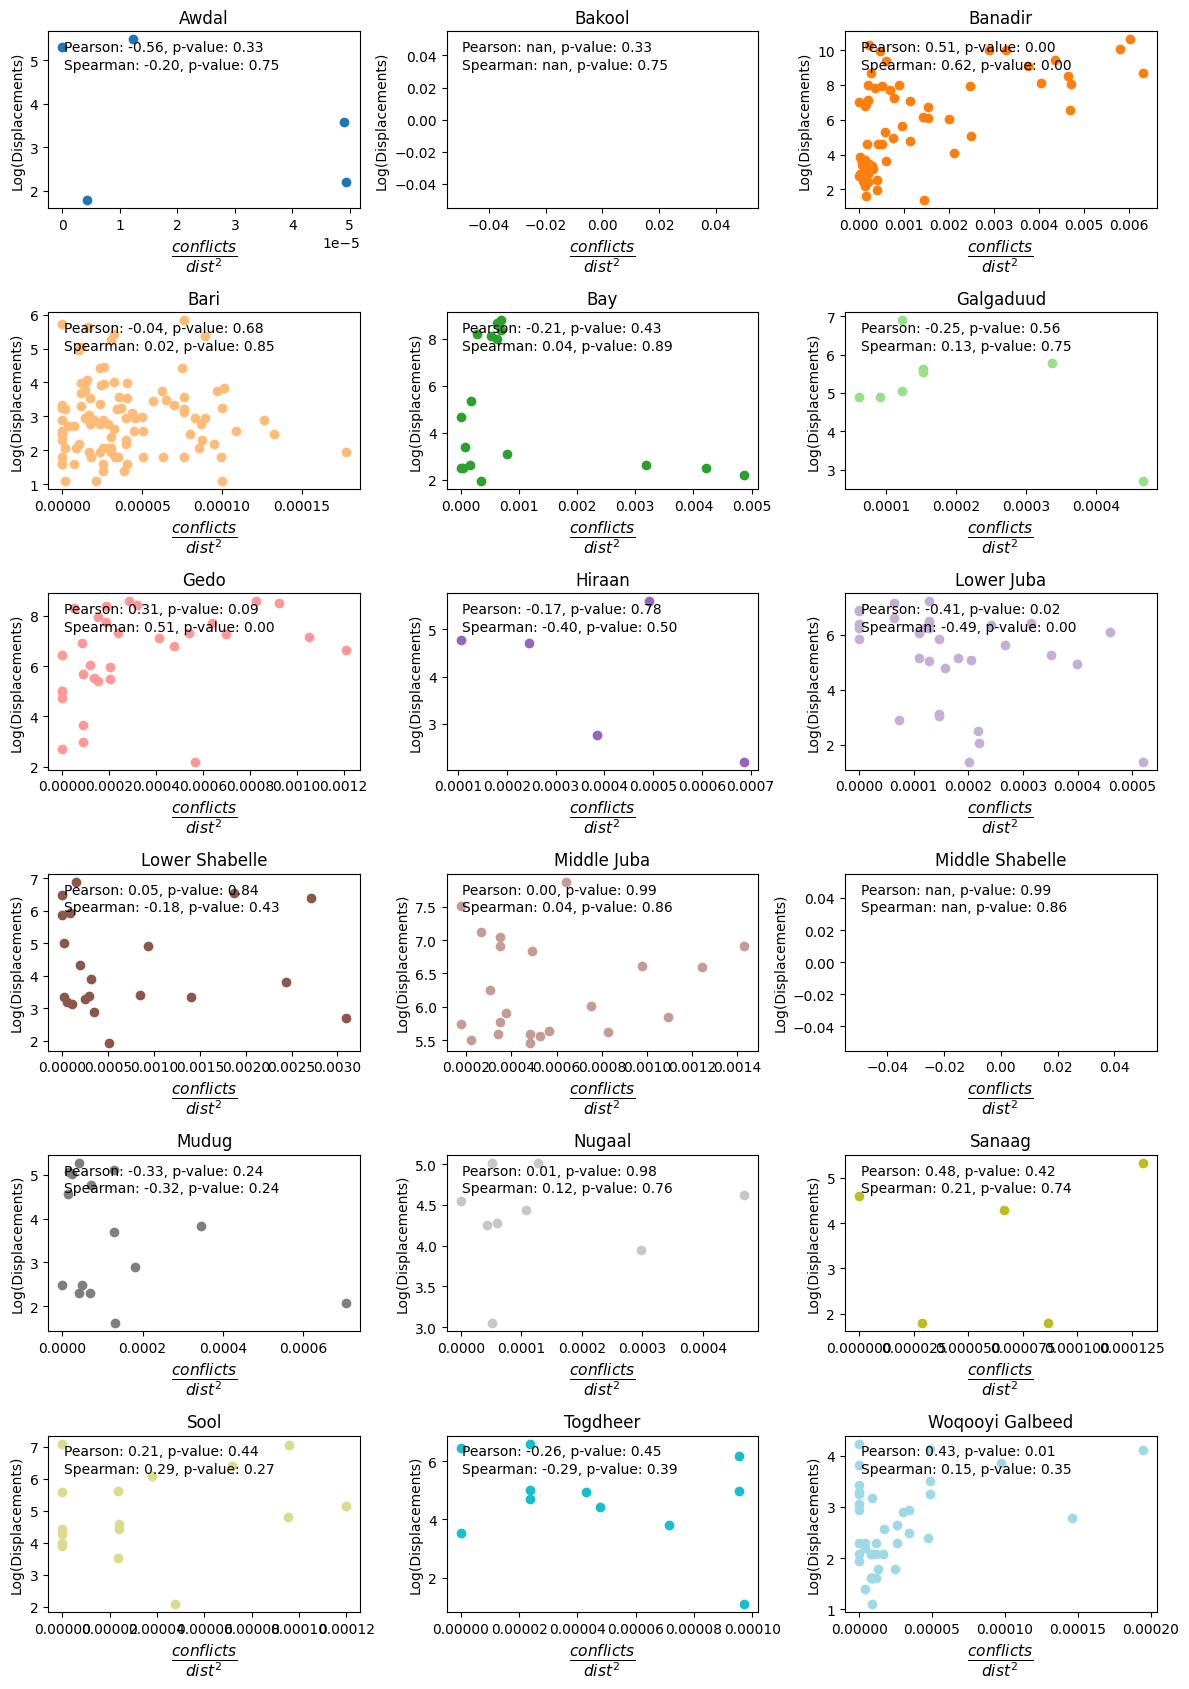

In [20]:
fig, axs = plt.subplots(6, 3, figsize=(12, 17))  

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['conflicts'] = df_m_y['conflicts']
            disp_reg = disp_reg[disp_reg[j]!=0]
            color = cmap(region_codes[regions == j][0])
            axs[row, col].scatter(disp_reg['conflicts']*disp_reg['inv_dist']**2, np.log(disp_reg[j]), color=color)
        
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['inv_dist']*df_j['conflicts'])]
    df_j = df_j[df_j['inv_dist']*df_j['inv_dist']*df_j['conflicts'] != np.nan]

    
    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan

    axs[row, col].set_xlabel(fr'$\frac{{conflicts}}{{dist^2}}$', fontsize=16)
    axs[row, col].set_ylabel('Log(Displacements)')
    axs[row, col].set_title(j)
    axs[row, col].text(0.05, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    axs[row, col].text(0.05, 0.85, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    
plt.tight_layout()
plt.savefig('scatter_conflicts_disp.png')
plt.show()

## Jointplot 

$$
Log(Disp_{ji}) = f(\frac{conflicts_{lag2, i}}{dist_{ji}})
$$

TypeError: len() of unsized object

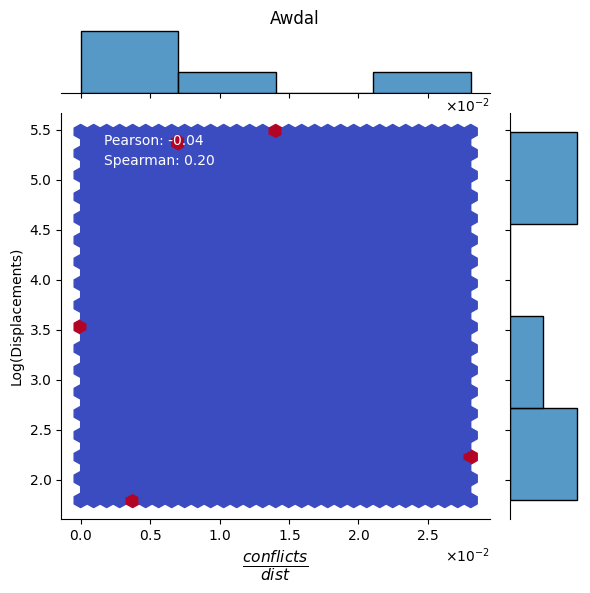

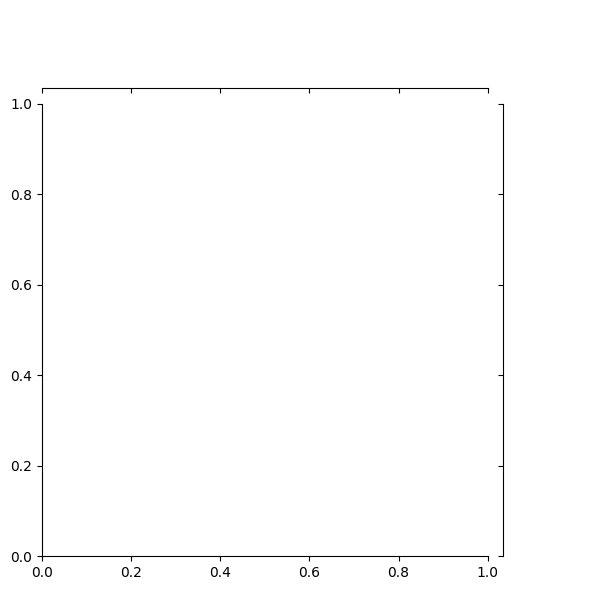

In [12]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['conflicts'] = df_m_y['conflicts']
            disp_reg = disp_reg[disp_reg[j]!=0] #remove rows with 0 displacements
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['conflicts'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['inv_dist']*df_j['conflicts'], df_j[j])
        corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['conflicts'], df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['conflicts']*df_j['inv_dist']

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{conflicts}}{{dist}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)
    
plt.show()

## Jointplot 

$$
Log(Disp_{ji}) = f(\frac{conflicts_i}{dist^2_{ji}})
$$

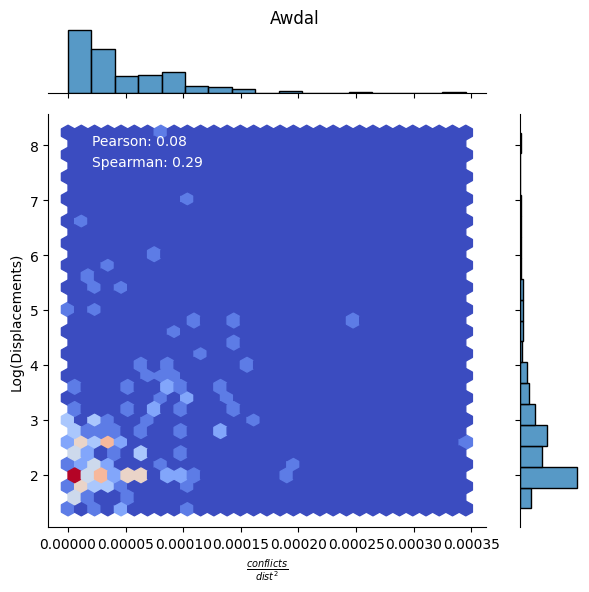

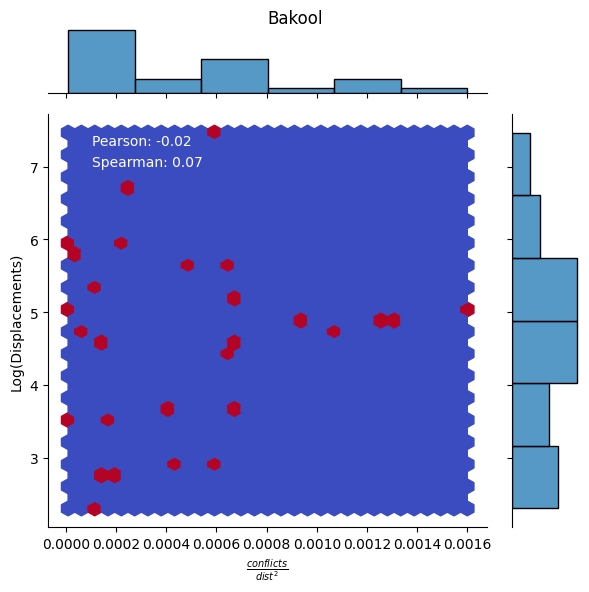

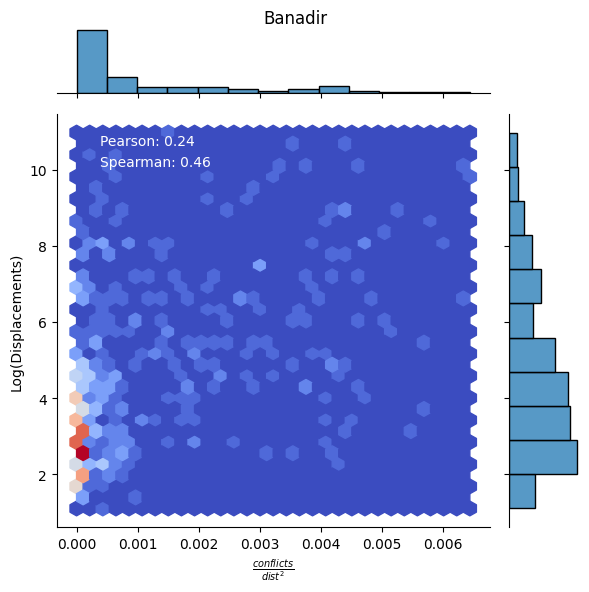

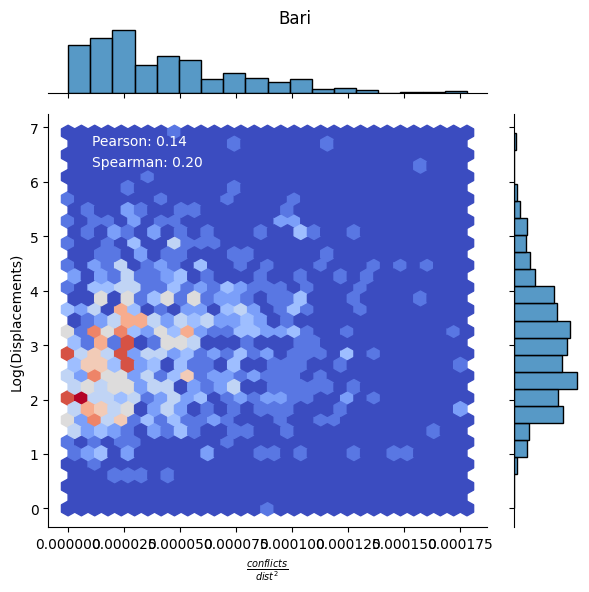

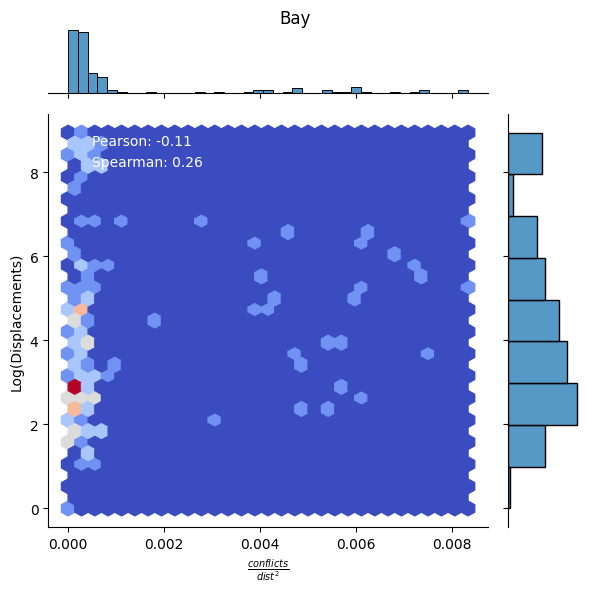

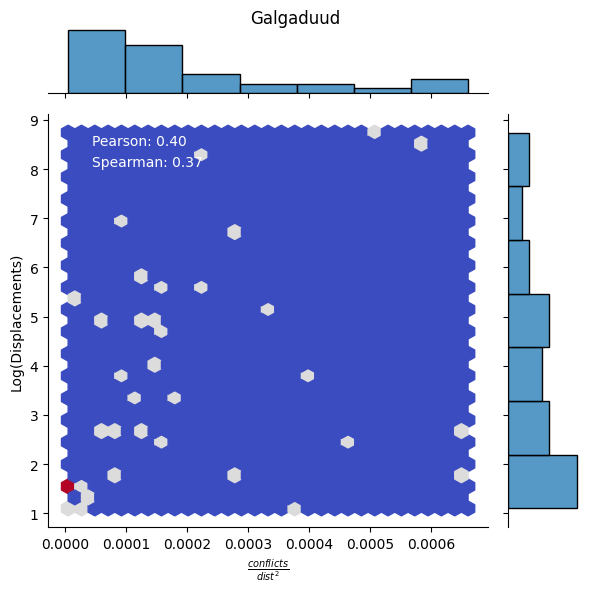

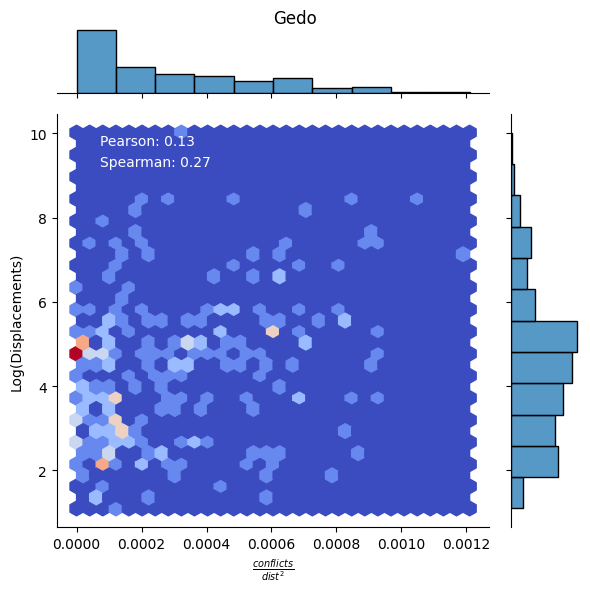

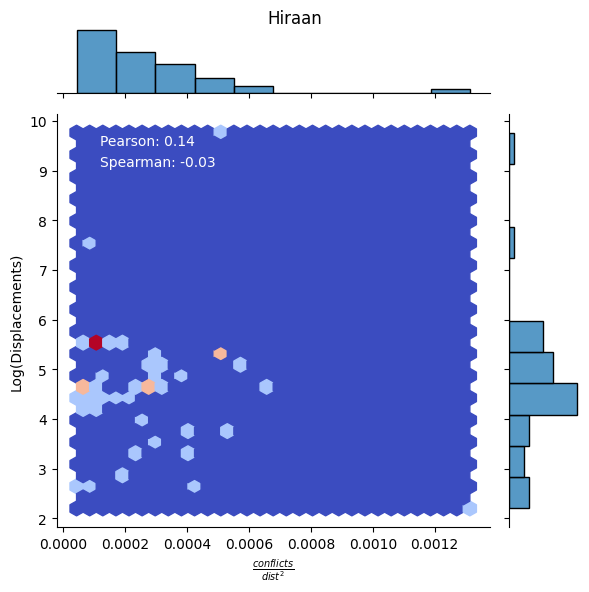

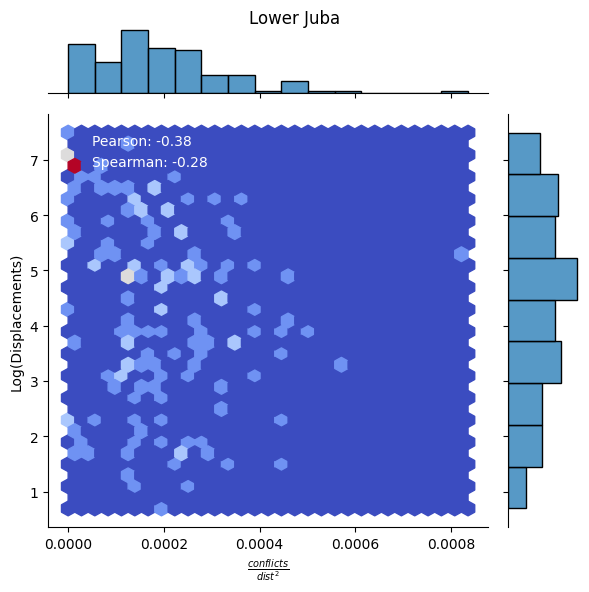

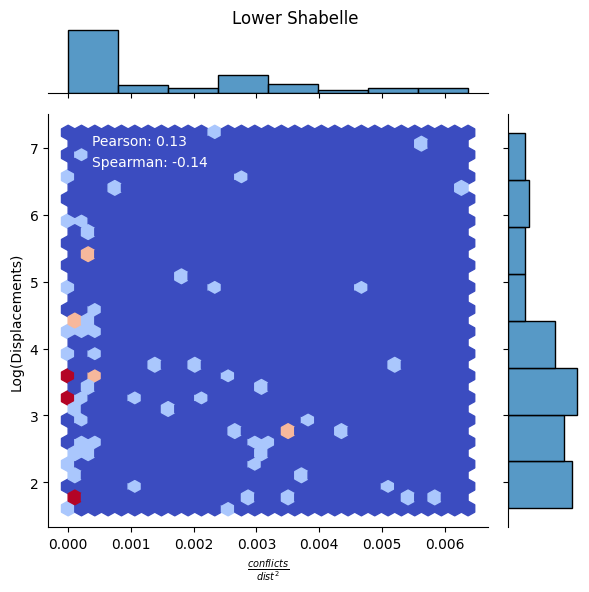

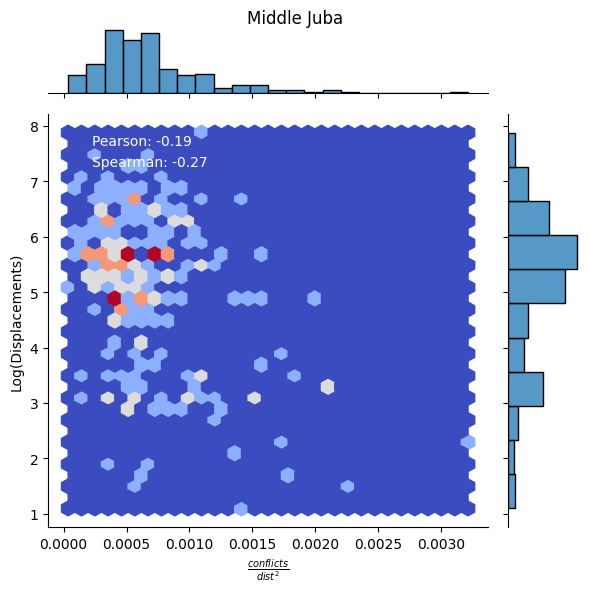

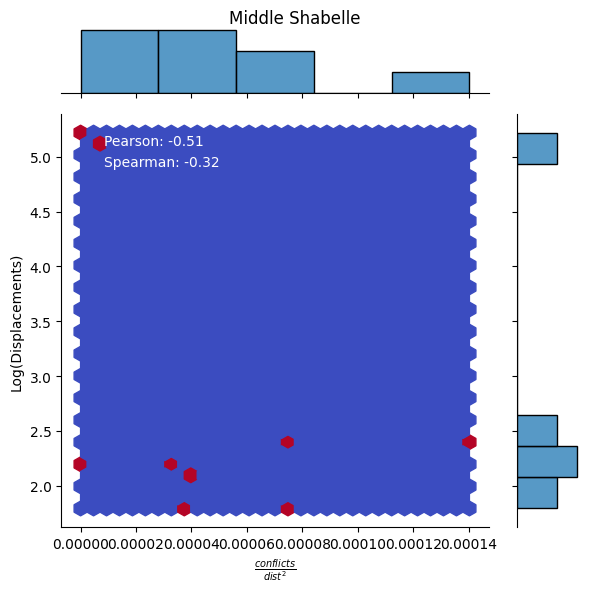

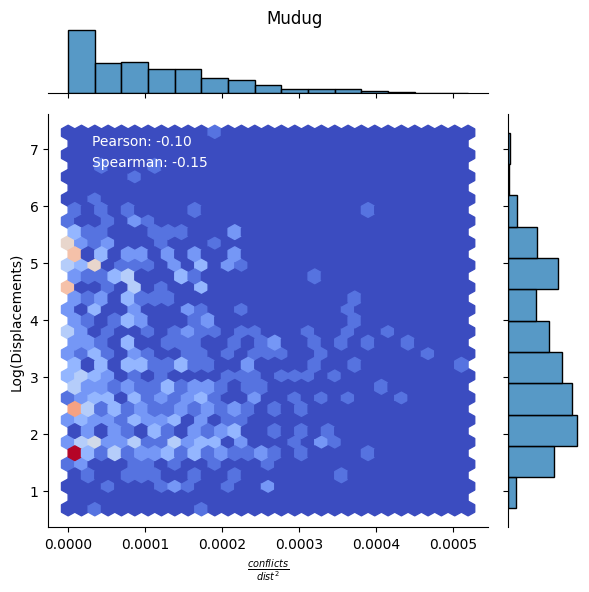

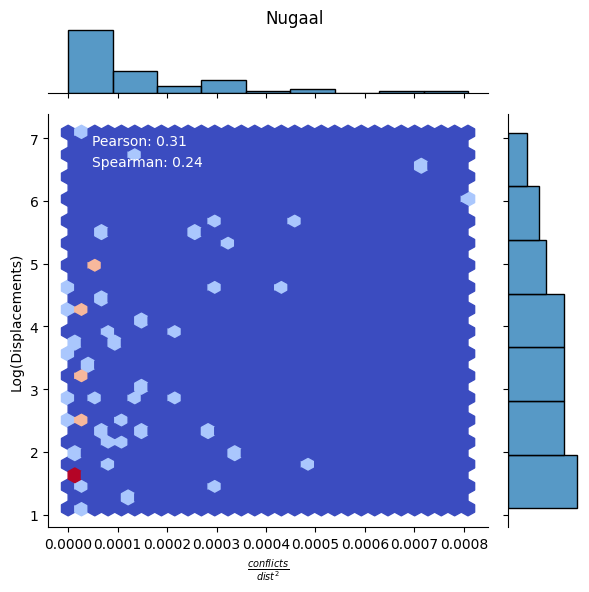

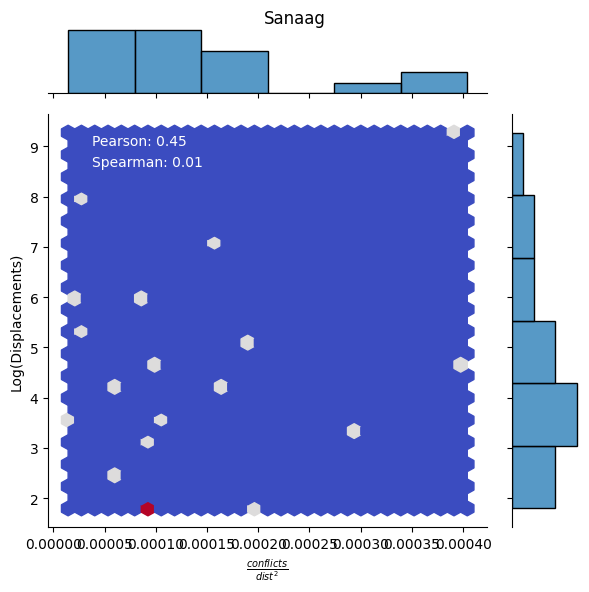

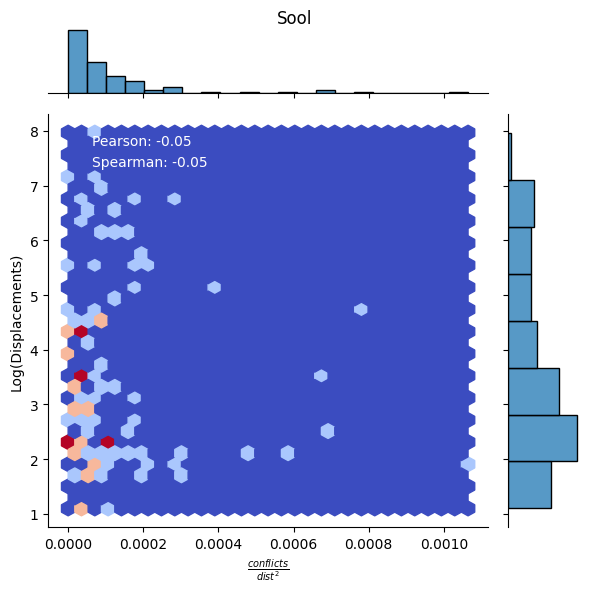

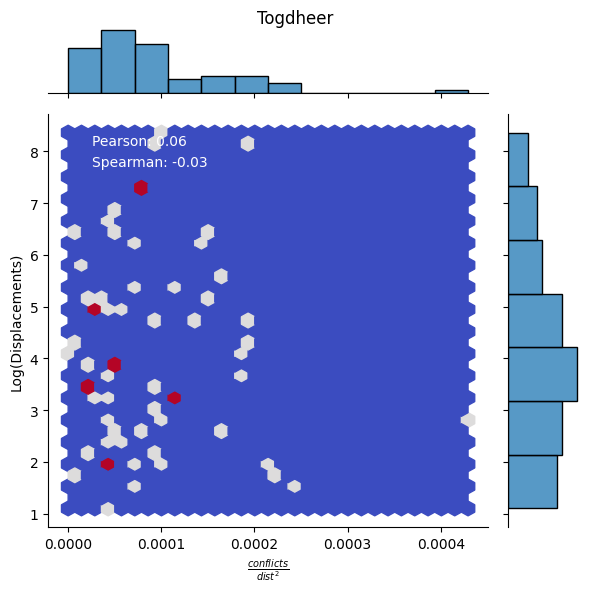

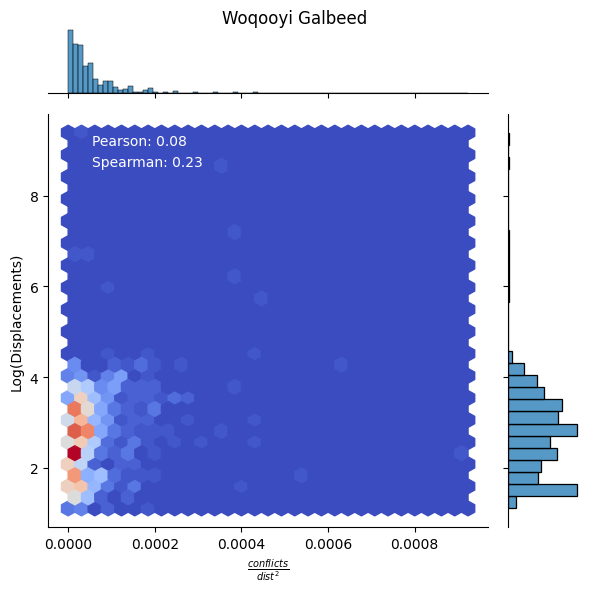

In [ ]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['conflicts'] = df_m_y['conflicts']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['conflicts']*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['conflicts']*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{conflicts}}{{dist^2}}$')
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')

plt.show()

## Heatmap Pearson and Spearman coefficient

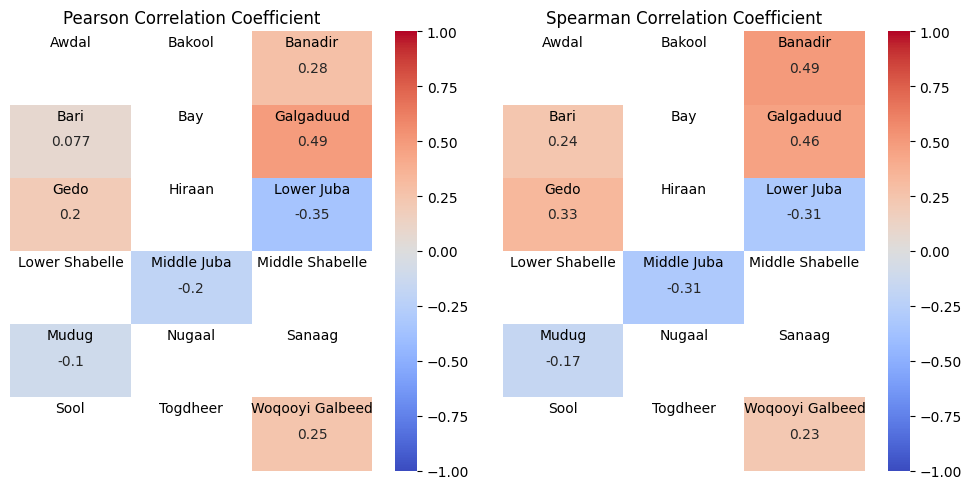

In [ ]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month)].reset_index()
            disp_reg['conflicts'] = df_m_y['conflicts']
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['conflicts'])]

    if len(df_j[j]) >= 2:
        corr_pearson, p_value = pearsonr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
        if p_value <= 0.05:
            vec_corr_pearson.append(corr_pearson)
        else:
            vec_corr_pearson.append(np.nan)

        if p_value <= 0.05:
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_spearman.append(np.nan)
        
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

## All regions together

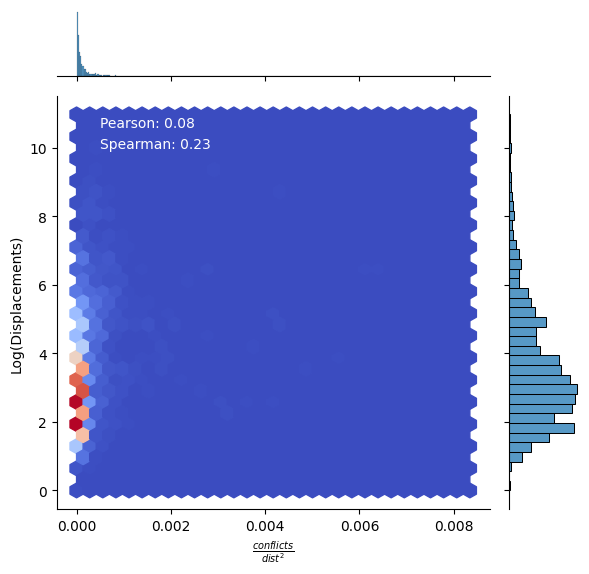

In [ ]:
vec_corr_pearson = []
vec_corr_spearman = []
vec_df = []
df_j_= []

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['conflicts'] = df_m_y['conflicts']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['conflicts']*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['conflicts']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    
    df_j['y'] = np.log(df_j[j])
    df_j['x'] = df_j['conflicts']*df_j['inv_dist']**2
    vec_df.append(df_j)

vec_corr_pearson.append(corr_pearson)
vec_corr_spearman.append(corr_spearman)
df_j_ = pd.concat(vec_df, ignore_index=True)

g = sns.jointplot(data=df_j_, x='x', y='y', kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
g.ax_joint.set_xlabel(fr'$\frac{{conflicts}}{{dist^2}}$')
g.ax_joint.set_ylabel('Log(Displacements)')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')

plt.show()

In [13]:
vec_corr_spearman = []
vec_p_values = []
disp_matxs_r['drought']['year'] = disp_matxs_r['drought'].index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs_r['drought'][disp_matxs_r['drought']['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_spearman, p_value = spearmanr(df_j['inv_dist']*df_j['TA_lag_n'], df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_spearman.append(corr_spearman)
            else:
                vec_corr_spearman.append(np.nan)
        else:
            vec_corr_spearman.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Spearman Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

NameError: name 'disp_matxs_r' is not defined


    #pearson
    #spearman

    #heatmp con regioni per righe e lag per colonne con il coeff di correlazione, per vedere se colonne sono piu significative
    #prova anche con PA e DL
    #diverse funz di distanza
    #per tutte le regioni distinte
    #e con tutte le regioni insieme
    #anzichè scatter heatmap dei punti (vedi seaborn, slack) 
    #(colora i punti proporzionalmente alla conflicts della regione di arrivo)
    #

## Correlation

In [ ]:
arrival = disp_data.groupby(['time','Current (Arrival) Region'])['Number of Individuals'].sum()

In [ ]:
disp_data.head()

,time,Previous (Departure) Region,Current (Arrival) Region,Number of Individuals
0,2016-01-31,Bakool,Bakool,0
1,2016-01-31,Bakool,Banadir,0
2,2016-01-31,Bakool,Bari,0
3,2016-01-31,Bakool,Bay,14
4,2016-01-31,Bakool,Galgaduud,0


In [ ]:
sum_dep = disp_data.groupby('Previous (Departure) Region')['Number of Individuals'].sum()
sum_dep= sum_dep.to_frame()

In [ ]:
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
states_gdf.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,5.657071,1.312224,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((43.46189 11.42429, 43.45532 11..."
1,6.650225,2.101389,Bakool,SO25,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.03028 4.95968, 44.08498 4.95730, ..."
2,1.068762,0.026612,Banadir,SO22,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((45.55389 2.15350, 45.55328 2.15308, ..."
3,12.218762,5.618064,Bari,SO16,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((50.79877 11.98356, 50.80576 11.97939..."
4,8.086913,3.572929,Bay,SO24,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.31110 3.57147, 44.31110 3.55957, ..."


In [ ]:
merged_shp_anx_mob = sum_dep.merge(states_gdf, left_on='Previous (Departure) Region', right_on='ADM1_EN')
merged_shp_anx_mob.head()

,Number of Individuals,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,53184,5.657071,1.312224,Awdal,SO11,Somalia,SO,2022-12-21,2023-03-08,NaN,"MULTIPOLYGON (((43.46189 11.42429, 43.45532 11..."
1,421067,6.650225,2.101389,Bakool,SO25,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.03028 4.95968, 44.08498 4.95730, ..."
2,54654,1.068762,0.026612,Banadir,SO22,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((45.55389 2.15350, 45.55328 2.15308, ..."
3,176573,12.218762,5.618064,Bari,SO16,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((50.79877 11.98356, 50.80576 11.97939..."
4,921943,8.086913,3.572929,Bay,SO24,Somalia,SO,2022-12-21,2023-03-08,NaN,"POLYGON ((44.31110 3.57147, 44.31110 3.55957, ..."
